In [9]:
!pip install gtfs_functions


In [1]:
!pip install gtfs_kit

In [103]:
#import packages
from gtfs_functions import Feed
import gtfs_kit as gk
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.ops import unary_union
import matplotlib.pyplot as plt

#### Import GTFS and Census Tract data

In [69]:
#Bring in GTFS data using gtfs_functions

#Change path to local GTFS zip
gtfs_path = r"C:\Users\cathk\GEOG490\google_transit.zip"
feed = Feed(gtfs_path, time_windows=[0, 6, 10, 12, 16, 19, 24])

In [70]:
routes = feed.routes
trips = feed.trips
stops = feed.stops
stop_times = feed.stop_times
shapes = feed.shapes
calendar = feed.calendar

INFO:root:Reading "routes.txt".
INFO:root:accessing trips
INFO:root:Start date is None. You should either specify a start date or set busiest_date to True.
INFO:root:Reading "trips.txt".
INFO:root:Reading "calendar.txt".
INFO:root:Reading "calendar_dates.txt".
INFO:root:The busiest date/s of this feed or your selected date range is/are:  ['2024-05-27'] with 27665 trips.
INFO:root:In the case that more than one busiest date was found, the first one will be considered.
INFO:root:In this case is 2024-05-27.
INFO:root:Reading "stop_times.txt".
INFO:root:_trips is defined in stop_times
INFO:root:Reading "stops.txt".
INFO:root:computing patterns
INFO:root:Reading "shapes.txt".


In [66]:
#Bring in Census Tract Data

#Change path to local tract shapefile
tracts = gpd.read_file(r"C:\Users\cathk\GEOG490\tl_2021_17_tract\tl_2021_17_tract.shp")

#Get Cook county Census tract
cook_tracts = tracts[tracts['COUNTYFP'] == '031']

#Reproject  Cook tracts to UTM 
cook_tracts = cook_tracts.to_crs("EPSG:32616")



ERROR:fiona._env:PROJ: proj_identify: C:\Users\cathk\miniconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_identify: C:\Users\cathk\miniconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [67]:
# Extract needed columns
cook_tracts = cook_tracts[['TRACTCE','ALAND','AWATER','geometry']]

# Transit Factors and Indicators

### Factor 1: Connectivity to the Network
##### Indicators: Bus stop service coverage area, density of bus stops, route coverage, ADA accessibility

#### Indicator: Bus stop service coverage area
Bus stop service coverage area is determined by finding the sum of the service coverage areas of bus stops in a Census tract divided by the total area of the Census tract.

 - Service coverage areas are 400m radius buffers from each bus stop. Here overlapping areas are counted one time.


In [71]:
# Bring in the bus stops
stops = feed.stops

#Reproject the bus stops to UTM
stops_reproject = stops.to_crs("EPSG:32616")

#buffer stops 
buffer_distance = 400 #meters
stops_buffered = stops_reproject.buffer(buffer_distance)

#Convert buffered stops geoseries to a geodataframe
stops_buffered_gdf = gpd.GeoDataFrame(geometry=stops_buffered)

In [72]:

# Calculate the intersection areas
cook_tracts['area'] = cook_tracts.geometry.area

In [73]:
# Merge all the polygons into a single polygon
merged_polygon = unary_union(stops_buffered_gdf.geometry)

# Create a new GeoDataFrame with the merged polygon
merged_gdf = gpd.GeoDataFrame(geometry=[merged_polygon])

# If you want to reset the index of the DataFrame
merged_gdf.reset_index(drop=True, inplace=True)


In [74]:
# Create an empty list to store the results
area_covered_list = []

# Iterate over each row in gdf2
for _, row in cook_tracts.iterrows():
    # Calculate the intersection between the row geometry of gdf2 and the geometries in gdf1
    intersection = merged_gdf.intersection(row.geometry)
    
    # Calculate the total area of the intersection
    total_intersection_area = intersection.area.sum()
    
    # Append the total intersection area to the list
    area_covered_list.append(total_intersection_area)

# Add the area_covered_list as a new column to gdf2
cook_tracts['area_covered'] = area_covered_list



In [75]:
cook_tracts['service_coverage']=cook_tracts['area_covered']/cook_tracts['area']

#### Indicator: Density of bus stops
The density of bus stops is determined by dividing the number of bus stops in a census tract by the area of the census tract

In [76]:
#Get the number of bus stops in a census tract

stops_county = stops_reproject.sjoin(cook_tracts, how="left")

stops_county['area'] = stops_county['geometry'].area


unique, counts = np.unique(stops_county['TRACTCE'], return_counts=True)
dict(zip(unique, counts))


busstopsincounty = gpd.GeoDataFrame(list(zip(unique, counts)), 
                       columns=['TRACTCE', 'bus_stops'])

cook_tracts = cook_tracts.merge(busstopsincounty, on='TRACTCE', how='left')
cook_tracts['density_bstops'] = cook_tracts['bus_stops']/cook_tracts['area']

#### Indicator: Route coverage
Route coverage quantifies the distribution and density of bus routes throughout the street network of the Census tract. This metric is calculated by taking the sum of the lengths of all routes in a census tract and dividing this by the sum of the length of the street network throughout the tract.

In [77]:
# Load the GTFS feed into a Feed object
feed = gk.read_feed(gtfs_path,dist_units='mi')


In [78]:
routesgeom = gk.routes.geometrize_routes(feed)

In [ ]:
routesgeom

In [79]:
routesgeom.crs = "EPSG:4326" 

#Reproject the routes to UTM
routes_reproject = routesgeom.to_crs("EPSG:32616")



In [ ]:
routes_reproject

In [80]:
# Get bus routes with type 3
routes_reproject = routes_reproject[routes_reproject['route_type'] == 3]

In [81]:
#sum length of bus routes in each tract

# Perform a spatial join to get the lines that intersect with the polygons
lines_within_polygons = gpd.overlay(routes_reproject, cook_tracts, how='intersection')

# Calculate the length of the resulting LineStrings
lines_within_polygons['length'] = lines_within_polygons.geometry.length

# Group by 'TRACTCE' to handle unique polygons and calculate the sum of the lengths for each
total_length_within_polygons = lines_within_polygons.groupby('TRACTCE')['length'].sum().reset_index()

total_length_within_polygons.rename(columns={'length': 'routesum'}, inplace=True)


total_length_within_polygons


,TRACTCE,routesum
0,010100,133.966434
1,010201,2004.417548
2,010202,5614.695244
3,010300,3520.804780
4,010400,3469.263037
...,...,...
893,843800,5001.560429
894,843900,31254.751262
895,844600,1823.464609
896,844700,3083.963744


In [ ]:
total_length_within_polygons

In [82]:
cook_tracts = cook_tracts.merge(total_length_within_polygons, on='TRACTCE', how='left')


In [83]:
cook_tracts

,TRACTCE,ALAND,AWATER,geometry,area,area_covered,service_coverage,bus_stops,density_bstops,routesum
0,221000,220053,0,"POLYGON ((440550.049 4641653.581, 440570.365 4...",2.198917e+05,219891.671793,1.000000,3.0,0.000014,705.074167
1,221100,440042,0,"POLYGON ((440820.061 4641655.880, 440826.943 4...",4.397288e+05,439728.803401,1.000000,13.0,0.000030,2512.715676
2,242800,439630,0,"POLYGON ((442206.390 4638425.562, 442226.962 4...",4.393132e+05,439313.154976,1.000000,13.0,0.000030,4226.811341
3,242900,323819,0,"POLYGON ((443024.390 4638428.848, 443065.044 4...",3.235872e+05,323587.160616,1.000000,9.0,0.000028,3520.991681
4,243000,324547,0,"POLYGON ((443430.438 4638434.936, 443471.091 4...",3.243118e+05,324311.806412,1.000000,12.0,0.000037,1426.360327
...,...,...,...,...,...,...,...,...,...,...
1327,050300,380031,14700,"POLYGON ((442426.603 4645709.824, 442440.277 4...",3.944459e+05,394215.618112,0.999416,6.0,0.000015,2670.123358
1328,830700,861986,7945,"POLYGON ((444814.024 4645731.063, 444830.929 4...",8.692976e+05,857669.965464,0.986624,29.0,0.000033,6666.802679
1329,834700,657991,0,"POLYGON ((445994.015 4627135.510, 446006.889 4...",6.575121e+05,657512.146495,1.000000,19.0,0.000029,3217.475997
1330,824123,3917329,25455,"POLYGON ((432193.967 4605905.521, 432261.895 4...",3.940064e+06,0.000000,0.000000,NaN,NaN,NaN


In [37]:
cook_tracts.crs

<Projected CRS: EPSG:32616>
Name: WGS 84 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 90°W and 84°W, northern hemisphere between equator and 84°N, onshore and offshore. Belize. Canada - Manitoba; Nunavut; Ontario. Costa Rica. Cuba. Ecuador - Galapagos. El Salvador. Guatemala. Honduras. Mexico. Nicaragua. United States (USA).
- bounds: (-90.0, 0.0, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [53]:
cook_tracts = cook_tracts.to_crs("EPSG:32616")

In [40]:
# find total street network length
import osmnx as ox
import geopandas as gpd

# Define your city or region of interest
place_name = "Chicago, Illinois, USA"

network_lengths = []
for geometry in cook_tracts['geometry']:

    
    # Retrieve the street network within the boundary of the Census Tract
    G = ox.graph_from_polygon(geometry, network_type='all')
    
     # Calculate the basic statistics of the street network within the Census Tract
    stats = ox.stats.basic_stats(G)
    
    # Extract the total length of the street network within the Census Tract
    total_length = stats['edge_length_total']
    
    network_lengths.append(total_length)

    print("count")
cook_tracts['net_len'] = network_lengths


count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
coun

KeyboardInterrupt: 

In [51]:
cookforarea['route_covg'] = cookforarea['routesum']/cookforarea['net_len']

#### Indicator: ADA accessibility
Here the number of stops with ADA ramps is used as a proxy for system-wide accesibility. The number of stops with ADA ramps is used here.

In [84]:
#Get the number of bus stops in a census tract
# Spatially join stops and census tracts
stops_county = gpd.sjoin(stops_reproject, cook_tracts, how="left")

# Filter stops with wheelchair value of 1
wheelchair_stops = stops_county[stops_county['wheelchair_boarding'] == 1]

# Count the number of wheelchair stops within each census tract
wheelchair_stops_count = wheelchair_stops.groupby('TRACTCE').size().reset_index(name='wheelchair_stops')

# Merge the counts with the cook_tracts GeoDataFrame
cook_tracts = cook_tracts.merge(wheelchair_stops_count, on='TRACTCE', how='left')


In [60]:
cook_tracts = cook_tracts.drop(['wheelchair_stops_x','wheelchair_stops_y'], axis=1)


## Create scores from transit supply indicators

In [89]:
from scipy.stats import zscore

In [90]:
cook_tracts

,TRACTCE,ALAND,AWATER,geometry,area,area_covered,service_coverage,bus_stops,density_bstops,routesum,wheelchair_stops
0,221000,220053,0,"POLYGON ((440550.049 4641653.581, 440570.365 4...",2.198917e+05,219891.671793,1.000000,3.0,0.000014,705.074167,3.0
1,221100,440042,0,"POLYGON ((440820.061 4641655.880, 440826.943 4...",4.397288e+05,439728.803401,1.000000,13.0,0.000030,2512.715676,13.0
2,242800,439630,0,"POLYGON ((442206.390 4638425.562, 442226.962 4...",4.393132e+05,439313.154976,1.000000,13.0,0.000030,4226.811341,13.0
3,242900,323819,0,"POLYGON ((443024.390 4638428.848, 443065.044 4...",3.235872e+05,323587.160616,1.000000,9.0,0.000028,3520.991681,9.0
4,243000,324547,0,"POLYGON ((443430.438 4638434.936, 443471.091 4...",3.243118e+05,324311.806412,1.000000,12.0,0.000037,1426.360327,12.0
...,...,...,...,...,...,...,...,...,...,...,...
1327,050300,380031,14700,"POLYGON ((442426.603 4645709.824, 442440.277 4...",3.944459e+05,394215.618112,0.999416,6.0,0.000015,2670.123358,6.0
1328,830700,861986,7945,"POLYGON ((444814.024 4645731.063, 444830.929 4...",8.692976e+05,857669.965464,0.986624,29.0,0.000033,6666.802679,28.0
1329,834700,657991,0,"POLYGON ((445994.015 4627135.510, 446006.889 4...",6.575121e+05,657512.146495,1.000000,19.0,0.000029,3217.475997,19.0
1330,824123,3917329,25455,"POLYGON ((432193.967 4605905.521, 432261.895 4...",3.940064e+06,0.000000,0.000000,NaN,NaN,NaN,NaN


In [91]:
print("Original DataFrame:")
print(cook_tracts)
print("\nChecking for NaN values:")
print(cook_tracts.isna().sum())
cook_dropped = cook_tracts.dropna()
cook_dropped

Original DataFrame:
     TRACTCE    ALAND  AWATER  \
0     221000   220053       0   
1     221100   440042       0   
2     242800   439630       0   
3     242900   323819       0   
4     243000   324547       0   
...      ...      ...     ...   
1327  050300   380031   14700   
1328  830700   861986    7945   
1329  834700   657991       0   
1330  824123  3917329   25455   
1331  804405  1674250       0   

                                               geometry          area  \
0     POLYGON ((440550.049 4641653.581, 440570.365 4...  2.198917e+05   
1     POLYGON ((440820.061 4641655.880, 440826.943 4...  4.397288e+05   
2     POLYGON ((442206.390 4638425.562, 442226.962 4...  4.393132e+05   
3     POLYGON ((443024.390 4638428.848, 443065.044 4...  3.235872e+05   
4     POLYGON ((443430.438 4638434.936, 443471.091 4...  3.243118e+05   
...                                                 ...           ...   
1327  POLYGON ((442426.603 4645709.824, 442440.277 4...  3.944459e+05   

,TRACTCE,ALAND,AWATER,geometry,area,area_covered,service_coverage,bus_stops,density_bstops,routesum,wheelchair_stops
0,221000,220053,0,"POLYGON ((440550.049 4641653.581, 440570.365 4...",2.198917e+05,2.198917e+05,1.000000,3.0,0.000014,705.074167,3.0
1,221100,440042,0,"POLYGON ((440820.061 4641655.880, 440826.943 4...",4.397288e+05,4.397288e+05,1.000000,13.0,0.000030,2512.715676,13.0
2,242800,439630,0,"POLYGON ((442206.390 4638425.562, 442226.962 4...",4.393132e+05,4.393132e+05,1.000000,13.0,0.000030,4226.811341,13.0
3,242900,323819,0,"POLYGON ((443024.390 4638428.848, 443065.044 4...",3.235872e+05,3.235872e+05,1.000000,9.0,0.000028,3520.991681,9.0
4,243000,324547,0,"POLYGON ((443430.438 4638434.936, 443471.091 4...",3.243118e+05,3.243118e+05,1.000000,12.0,0.000037,1426.360327,12.0
...,...,...,...,...,...,...,...,...,...,...,...
1324,440201,531454,0,"POLYGON ((448872.553 4622326.008, 448885.773 4...",5.310625e+05,5.303250e+05,0.998611,12.0,0.000023,1961.940422,12.0
1325,540101,3357305,508399,"POLYGON ((448264.432 4611157.472, 448272.330 4...",3.862848e+06,1.173475e+06,0.303785,13.0,0.000003,4995.748628,13.0
1327,050300,380031,14700,"POLYGON ((442426.603 4645709.824, 442440.277 4...",3.944459e+05,3.942156e+05,0.999416,6.0,0.000015,2670.123358,6.0
1328,830700,861986,7945,"POLYGON ((444814.024 4645731.063, 444830.929 4...",8.692976e+05,8.576700e+05,0.986624,29.0,0.000033,6666.802679,28.0


In [ ]:
# List of columns to convert to numeric
columns_to_convert = ['percent_higher_ed', 'percent_vehicle_access', 'percent_employed',
       'percent_citizen', 'percent_english_speaking', 'percent_older_60',
       'percent_younger_19', 'percent_disability', 'percent_transit']

# Convert specified columns to numeric
df[columns_to_convert] = df[columns_to_convert].apply(lambda col: pd.to_numeric(col, errors='coerce'))

print("\nDataFrame after converting specified columns to numeric:")
print(df)

In [92]:
# Standarize Data
columns_to_standardize = ['service_coverage','density_bstops','routesum','wheelchair_stops']

# Calculate z-scores for the specified columns
cook_dropped[columns_to_standardize] = cook_dropped[columns_to_standardize].apply(zscore)
print("\nDataFrame with z-scores:")
print(cook_dropped)


DataFrame with z-scores:
     TRACTCE    ALAND  AWATER  \
0     221000   220053       0   
1     221100   440042       0   
2     242800   439630       0   
3     242900   323819       0   
4     243000   324547       0   
...      ...      ...     ...   
1324  440201   531454       0   
1325  540101  3357305  508399   
1327  050300   380031   14700   
1328  830700   861986    7945   
1329  834700   657991       0   

                                               geometry          area  \
0     POLYGON ((440550.049 4641653.581, 440570.365 4...  2.198917e+05   
1     POLYGON ((440820.061 4641655.880, 440826.943 4...  4.397288e+05   
2     POLYGON ((442206.390 4638425.562, 442226.962 4...  4.393132e+05   
3     POLYGON ((443024.390 4638428.848, 443065.044 4...  3.235872e+05   
4     POLYGON ((443430.438 4638434.936, 443471.091 4...  3.243118e+05   
...                                                 ...           ...   
1324  POLYGON ((448872.553 4622326.008, 448885.773 4...  5.310625e

In [93]:
# Sum the z-scores across the specified columns
cook_dropped['transit_supply_score'] = cook_dropped[columns_to_standardize].sum(axis=1)
print("\nDataFrame with transit supply scores:")
print(cook_dropped)


DataFrame with transit supply scores:
     TRACTCE    ALAND  AWATER  \
0     221000   220053       0   
1     221100   440042       0   
2     242800   439630       0   
3     242900   323819       0   
4     243000   324547       0   
...      ...      ...     ...   
1324  440201   531454       0   
1325  540101  3357305  508399   
1327  050300   380031   14700   
1328  830700   861986    7945   
1329  834700   657991       0   

                                               geometry          area  \
0     POLYGON ((440550.049 4641653.581, 440570.365 4...  2.198917e+05   
1     POLYGON ((440820.061 4641655.880, 440826.943 4...  4.397288e+05   
2     POLYGON ((442206.390 4638425.562, 442226.962 4...  4.393132e+05   
3     POLYGON ((443024.390 4638428.848, 443065.044 4...  3.235872e+05   
4     POLYGON ((443430.438 4638434.936, 443471.091 4...  3.243118e+05   
...                                                 ...           ...   
1324  POLYGON ((448872.553 4622326.008, 448885.773 4.

In [95]:
# Group the transit supply scores into quartiles
cook_dropped['quartile'] = pd.qcut(cook_dropped['transit_supply_score'], 4, labels=['Low', 'Moderate-Low', 'Moderate-High', 'High'])
print("\nDataFrame with transit supply score quartiles:")
print(cook_dropped)


DataFrame with transit supply score quartiles:
     TRACTCE    ALAND  AWATER  \
0     221000   220053       0   
1     221100   440042       0   
2     242800   439630       0   
3     242900   323819       0   
4     243000   324547       0   
...      ...      ...     ...   
1324  440201   531454       0   
1325  540101  3357305  508399   
1327  050300   380031   14700   
1328  830700   861986    7945   
1329  834700   657991       0   

                                               geometry          area  \
0     POLYGON ((440550.049 4641653.581, 440570.365 4...  2.198917e+05   
1     POLYGON ((440820.061 4641655.880, 440826.943 4...  4.397288e+05   
2     POLYGON ((442206.390 4638425.562, 442226.962 4...  4.393132e+05   
3     POLYGON ((443024.390 4638428.848, 443065.044 4...  3.235872e+05   
4     POLYGON ((443430.438 4638434.936, 443471.091 4...  3.243118e+05   
...                                                 ...           ...   
1324  POLYGON ((448872.553 4622326.008, 4488

In [96]:
#MIGHT NOT NEED THIS BECAUSE IT IS ALREADY A GDF
gdf = gpd.GeoDataFrame(cook_dropped, geometry=cook_dropped['geometry'])


In [114]:
# Convert the categorical column to a string
gdf['quartile'] = gdf['quartile'].astype(str)


gdf.to_file(r"C:\Users\cathk\GEOG490\chicago_transit_supply.shp")


In [101]:
# Load Chicago Boundary
boundary = gpd.read_file(r"C:\Users\cathk\GEOG490\cityboundary.shp")

ERROR:fiona._env:PROJ: proj_identify: C:\Users\cathk\miniconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_identify: C:\Users\cathk\miniconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


quartile
Low              221
Moderate-High    220
Moderate-Low     220
High             220
Name: count, dtype: int64


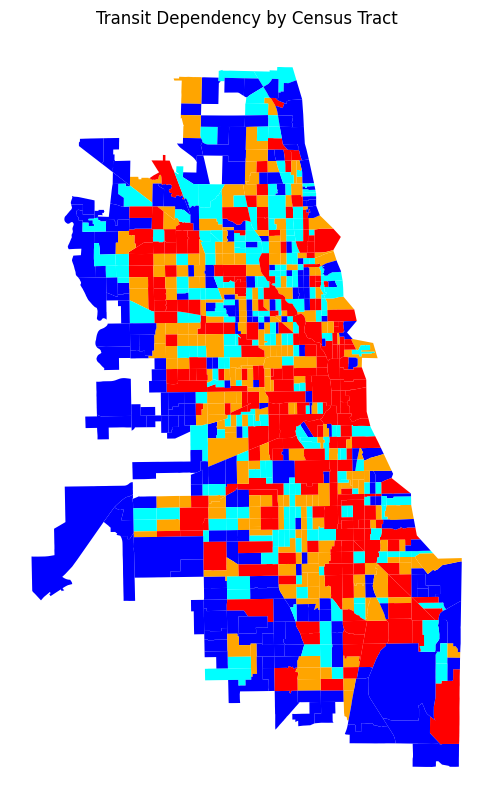

In [104]:
# Define the GeoDataFrame (you should replace this with your actual data loading code)
# Ensure 'quartile' column exists and contains the expected values
print(gdf['quartile'].value_counts())

# Define a color map for the quartiles
quartile_colors = {
    'Low': 'blue',
    'Moderate-Low': 'cyan',
    'Moderate-High': 'orange',
    'High': 'red'
}

# Plot the GeoDataFrame with the specified colors for quartiles
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf.plot(column='quartile', 
         ax=ax, 
         legend=True,
         legend_kwds={'title': "Transit Dependency Quartiles"},
         color=[quartile_colors[q] for q in gdf['quartile']])

# Add a title and axes labels
ax.set_title('Transit Dependency by Census Tract')
ax.set_axis_off()

# Show the plot
plt.show()

In [106]:
!pip install contextily

     ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
     --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
     ------------ ------------------------ 41.0/125.4 kB 487.6 kB/s eta 0:00:01
     ------------------------------------ 125.4/125.4 kB 921.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
     ---------------------------------------- 40.3/40.3 kB ? eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#add in supply gdf here

CRSError: The WKT could not be parsed. OGR Error code 6

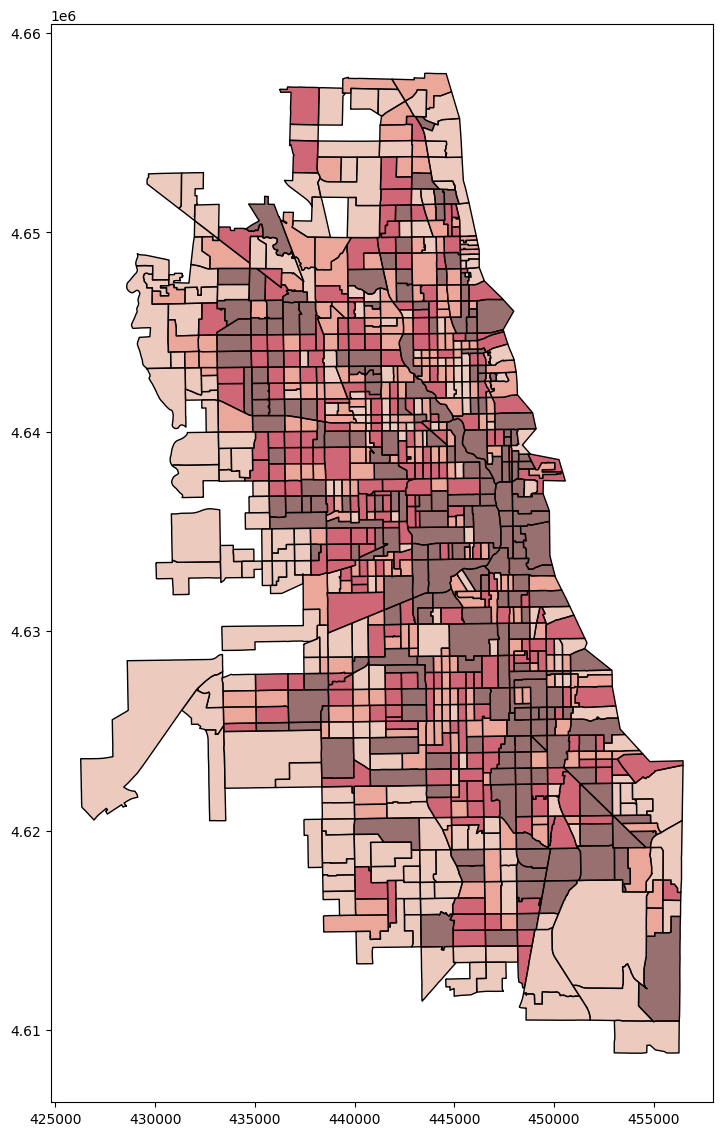

In [110]:
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import box  # Import the box function
import matplotlib.patches as mpatches


# Ensure both GeoDataFrames use the same CRS
gdf.crs = boundary.crs

# Get the bounding box of the city boundary
minx, miny, maxx, maxy = boundary.total_bounds

# Clip the GeoDataFrame to the city boundary
clip_box = box(minx, miny, maxx, maxy)

#gdf = gdf[gdf.geometry.intersects(clip_box)]

# Define a color map for the quartiles
quartile_colors = {
    'Low': "#e1a69298",
    'Moderate-Low': "#de6e5698",
    'Moderate-High': "#b0001b98",
    'High': "#540f0f98"
}

# Plotting the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Specify the CRS for the basemap
basemap_crs = gdf.crs.to_string()

# Plot the GeoDataFrame with the specified CRS
gdf.plot(ax=ax,
         legend=True,
         legend_kwds={'title': "Transit Demand Quartiles"},
         color=[quartile_colors[q] for q in gdf['quartile']],
         edgecolor='black')

# Add a basemap with the same CRS as the GeoDataFrame
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12, crs=gdf.crs)

# Add a legend with custom color patches
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in quartile_colors.items()]
ax.legend(handles=legend_handles, title='Transit Supply Quartiles', loc='lower right')


# Add a title and axes labels
ax.set_title('Transit Supply by Census Tract')
ax.set_axis_off()

# Show the plot
plt.show()